In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split

from read_datasets import DATA_PATH
from multiprocessing import Pool # for reading the CSVs faster

TESTING = False # Use this run with less data
CV = 10 # Amount of folds in cross validation

# Read the data

In [2]:
def my_read_csv(filename):
    # Helper function for the parellel load_csvs
    return pd.read_csv(filename)

def load_csvs(prefix):
    """Reads and joins all our CSV files into one big dataframe.
    We do it in parallel to make it faster, since otherwise it takes some time.
    Idea from: https://stackoverflow.com/questions/36587211/easiest-way-to-read-csv-files-with-multiprocessing-in-pandas
    
    """
    # set up your pool
    pool = Pool() 
    file_list = [f"{DATA_PATH}/{prefix}{idx}.csv" for idx in range(1, 21)]
    df_list = pool.map(my_read_csv, file_list)

    # reduce the list of dataframes to a single dataframe
    return pd.concat(df_list, ignore_index=True)

In [3]:
%%time
icmc_df = load_csvs("icmc")
original_df = load_csvs("original")

if TESTING:
    icmc_df = icmc_df.sample(n=100)
    original_df = original_df.sample(n=100)
    CV = 2

CPU times: user 586 ms, sys: 227 ms, total: 813 ms
Wall time: 26.6 s




- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

In [4]:
precisions = []

def calculate_average_precision(confusion_matrix):    
    """ Calculate Average Precision on Multiclass Dataset
    
    We use the formula: 
        Precision[i] = TP[i] / (TP[i] + FP[i] = Sum of Column[i])
    """ 
    # Helper function to deal with division by 0
    def weird_division(n, d):
        return n / d if d else 0

    [precisions.append(weird_division(confusion_matrix[i][i], 
                                      np.sum(confusion_matrix, axis=0)[i])) 
         for i in range(confusion_matrix.shape[0])]        
    return np.mean(precisions)

# Classify without processing

In [5]:
def run_models(x, y, processing="Nenhum",
               names=["3-NN", "5-NN", "7-NN"],# "MLP-1L", "MLP-2L"],
               models=[KNeighborsClassifier(n_neighbors=3), 
                       KNeighborsClassifier(n_neighbors=5), 
                       KNeighborsClassifier(n_neighbors=7),
                       #MLPClassifier(solver="sgd", hidden_layer_sizes=(90, ), momentum=1),
                       #MLPClassifier(solver="sgd", hidden_layer_sizes=(90, 40, ), momentum=0.3),
                      ], 
               result_cols=["Score", "Model", "Pré-Processamento"],
              other_metrics=False):
    
    model_results = []
    all_results = pd.DataFrame(columns=result_cols)
    results = pd.DataFrame(columns=["Confusion_Matrix", "Accuracy", "Precision", "Model", "Pré-Processamento"])

    for model, name in zip(models, names):
        y_pred = cross_val_predict(model, x, y, cv=CV, n_jobs=-1)
        conf_mat = confusion_matrix(y, y_pred)

        acc = accuracy_score(y, y_pred)
        precision = calculate_average_precision(conf_mat)        

        results.loc[len(results)] = [conf_mat, acc, precision, name, processing]
        if other_metrics:
            pass
        else:
            # By default, cross_val_score is stratified by Y automatically!
            mean_score = cross_val_score(model, x, y, scoring="accuracy", 
                                         cv=CV, n_jobs=-1).mean()
            model_results.append(mean_score)
            all_results.loc[len(all_results)] = [mean_score, name, processing]
    return all_results, results

In [6]:
icmc_results, icmc_matrix = run_models(icmc_df.drop(columns="target"), icmc_df["target"])

In [7]:
original_results, original_matrix = run_models(original_df.drop(columns="target"), icmc_df["target"])

## Show results

In [13]:
# Fonte: https://www.tarekatwan.com/index.php/2017/12/how-to-plot-a-confusion-matrix-in-python/
def plot_confusion_matrix(cm, name, dataset, file_prefix="orl", save=True):
    """Pretty print a confusion matrix in Python
    
    Parameters
    ----------
    cm : numpy.narray
        Confusion matrix generated 
        
    name : str
        Name of the confusion matrix
        
    dataset : str
            Name of the dataset used
    """
    plt.figure(figsize=(16,9))
    class_names = icmc_df["target"].unique()
    fig = sns.heatmap(cm, square=True, annot=True, fmt="d", cbar=False, 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{dataset}\nMatriz de Confusão: {name}')
    plt.ylabel('Classe Real')
    plt.xlabel('Classe Predita')    
    
    if save:
        fig = fig.get_figure()
        name  = f"pics/{file_prefix}-{name.replace('-', '')}-matrix.png".lower()
        fig.savefig(name)
    plt.show()

In [14]:
def plot_results(results, name, use_hue=False, y_name="Score", xlabel="Acurácia",
                file_prefix="orl", save=True):
    """Plots the results of a experiment
    
    Parameters
    ----------
    results : pd.DataFrame
        Should have the columns "Score", "Modelo", "Pré-Processamento"
        
    name : str
        Name of the data used
        
    use_hue : bool
            Weather or not to color by the column "Pré-Processamento"
    """
    if use_hue:
        fig = sns.barplot(y=y_name, x="Model", data=results, hue="Pré-Processamento")
    else:
        fig = sns.barplot(y=y_name, x="Model", data=results)
    plt.xlabel("Modelo")
    plt.xlabel(xlabel)
    plt.title(f"{xlabel} entre os modelos para os dados {name}");
    
    # Save and show image
    if save:
        fig = fig.get_figure()
        name = f"pics/{file_prefix}-{y_name}.png".lower()
        fig.savefig(name)
    plt.show()

In [15]:
def plot_result(results, name, use_hue=False, file_prefix="orl", save=True):
    # Confusion Matrix
    for i in range(len(results)):
        plot_confusion_matrix(results["Confusion_Matrix"][i], 
                              results["Model"][i], name, file_prefix=file_prefix,
                             save=save)
    print()
    
    plot_results(results, name, use_hue=use_hue,
                 y_name="Accuracy", xlabel="Acurácia", file_prefix=file_prefix,
                 save=save)
    plot_results(results, name, use_hue=use_hue,
                 y_name="Precision", xlabel="Precisão", file_prefix=file_prefix,
                 save=save)


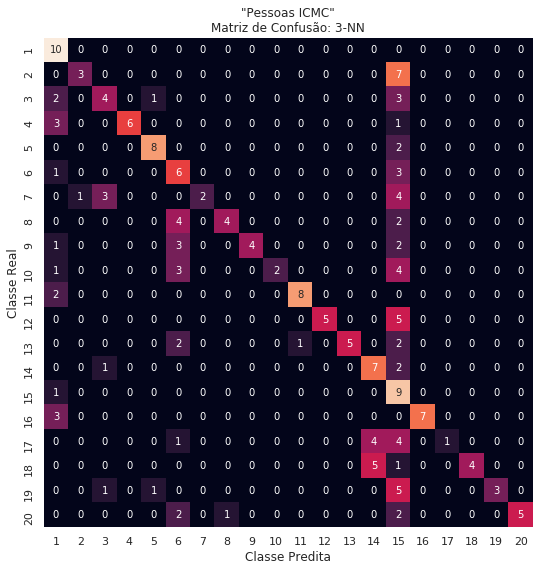

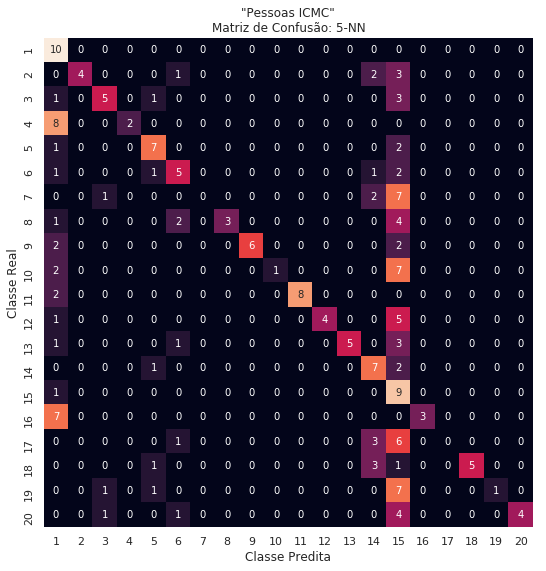

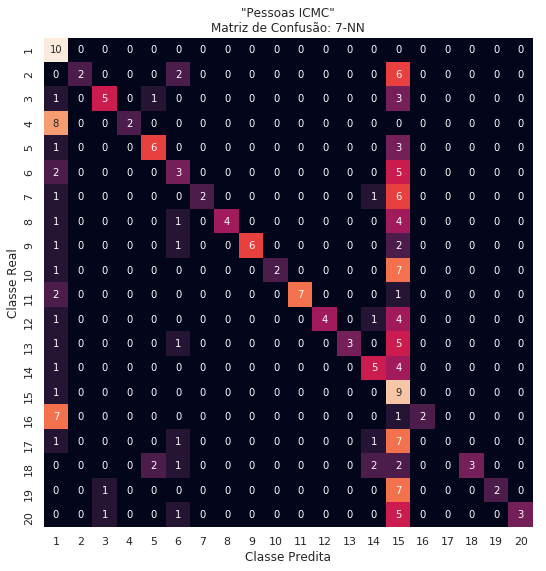

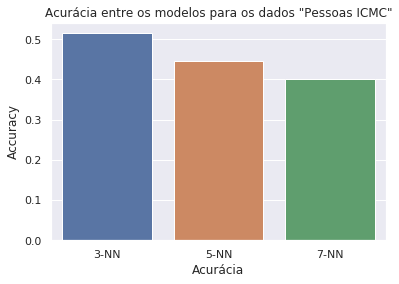

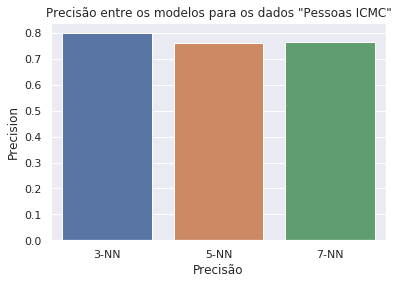

In [17]:
plot_result(icmc_matrix, "\"Pessoas ICMC\"", file_prefix="icmc_sem_proc")

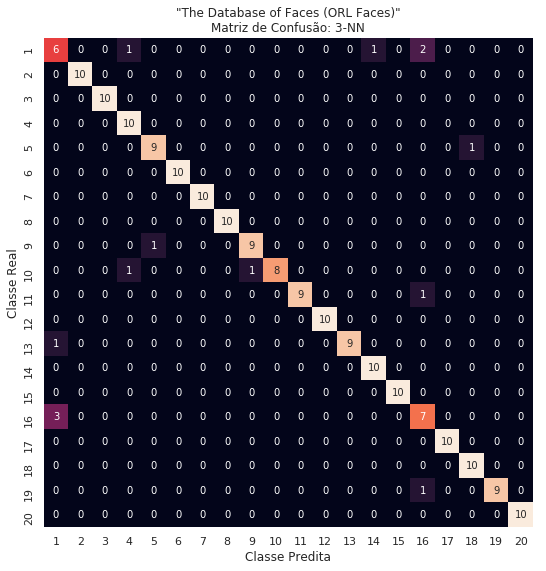

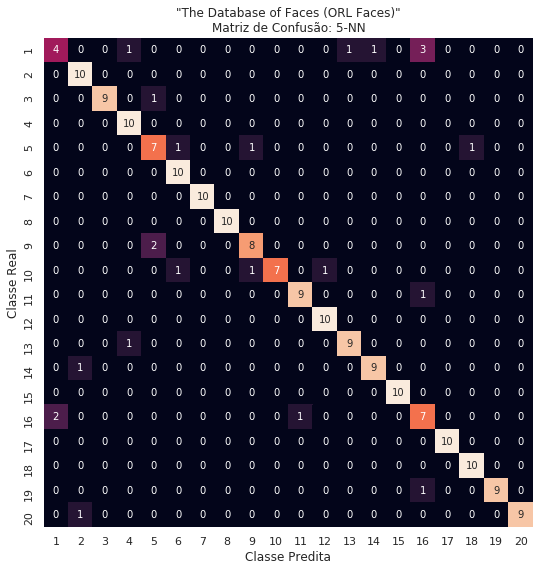

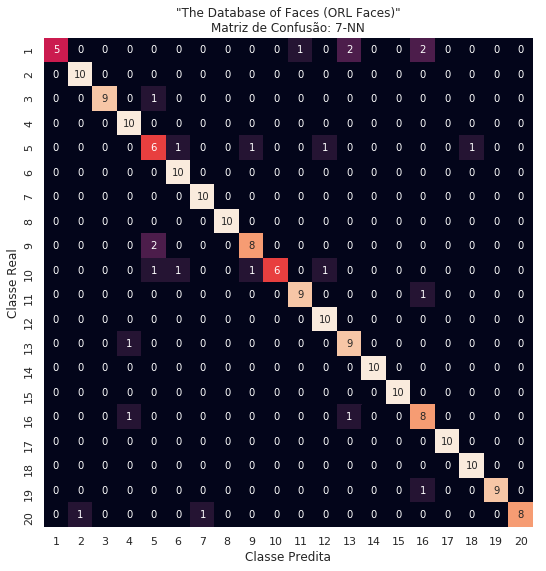

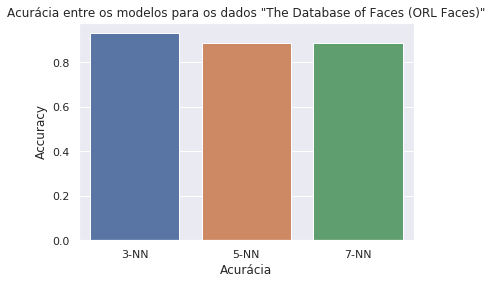

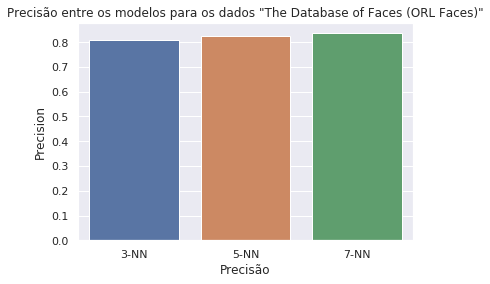

In [18]:
plot_result(original_matrix, "\"The Database of Faces (ORL Faces)\"",
           file_prefix="orl_sem_proc")

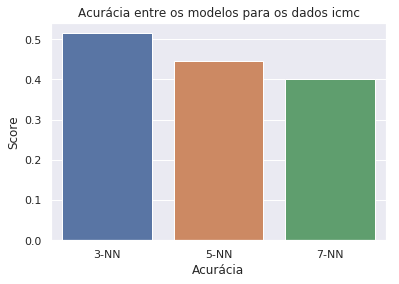

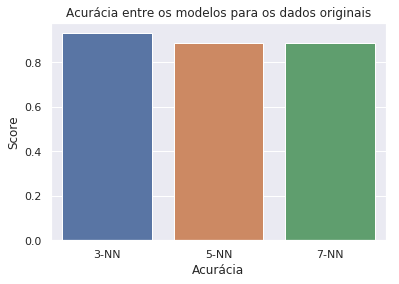

In [19]:
plot_results(icmc_results, "icmc", file_prefix="icmc", save=False)
plot_results(original_results, "originais", file_prefix="orl", save=False)



- - - 

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Apply PCA

In [20]:
def apply_pca(data, pca_percentage=0.5):
    # We must use "full" for solver otherwise we can't use a percentage
    pca =  PCA(n_components=pca_percentage,  svd_solver="full") 
    new_data = pca.fit_transform(data.drop(columns="target"))
    new_data = pd.DataFrame(new_data)
    new_data["target"] = data["target"].copy(deep=True)
    
    print(f"Explicando {pca_percentage*100}% dos dados, o PCA encontrou os", 
         f"{len(pca.explained_variance_)} melhores autovetores\n\n")
    return new_data

In [21]:
%%time
original_pca = apply_pca(original_df)

Explicando 50.0% dos dados, o PCA encontrou os 17 melhores autovetores


CPU times: user 1.41 s, sys: 744 ms, total: 2.16 s
Wall time: 323 ms


In [22]:
%%time
icmc_pca = apply_pca(icmc_df)

Explicando 50.0% dos dados, o PCA encontrou os 49 melhores autovetores


CPU times: user 19.3 s, sys: 6.42 s, total: 25.7 s
Wall time: 3.83 s


In [23]:
icmc_results = icmc_results.append(run_models(icmc_pca.drop(columns="target"), 
                                              icmc_pca["target"], processing="PCA")[0],
                                   ignore_index=True)
icmc_matrix = icmc_matrix.append(run_models(icmc_pca.drop(columns="target"), icmc_pca["target"], processing="PCA")[1], ignore_index=True)


In [24]:
original_results = original_results.append(run_models(original_pca.drop(columns="target"), 
                                              original_pca["target"], processing="PCA")[0],
                                   ignore_index=True)
original_matrix = original_matrix.append(run_models(original_pca.drop(columns="target"), original_pca["target"], processing="PCA")[1], ignore_index=True)

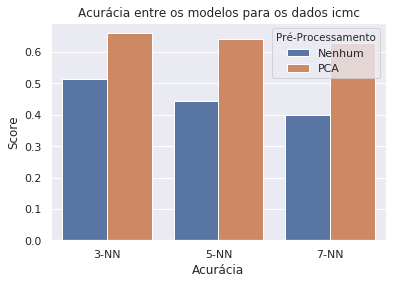

In [25]:
plot_results(icmc_results, name="icmc", use_hue=True, save=False)

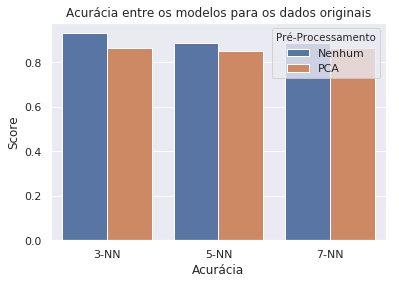

In [26]:
plot_results(original_results, name="originais", use_hue=True, save=False)

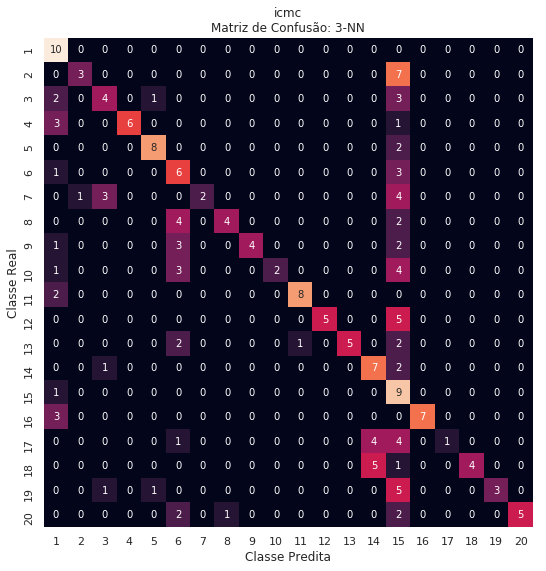

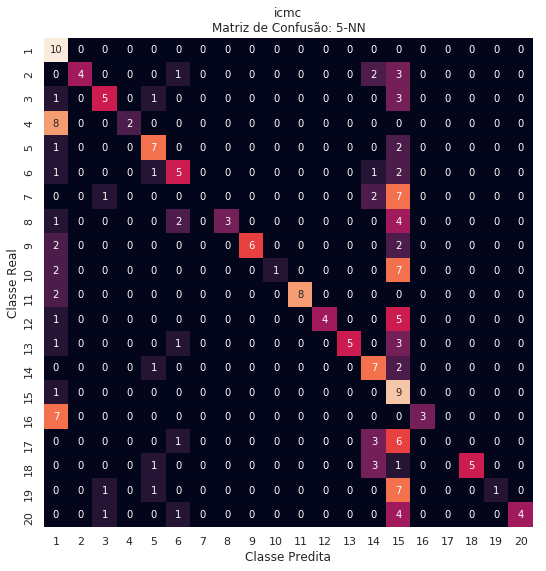

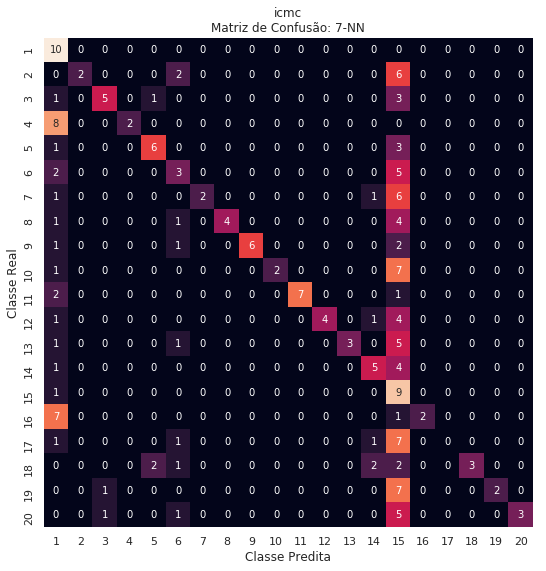

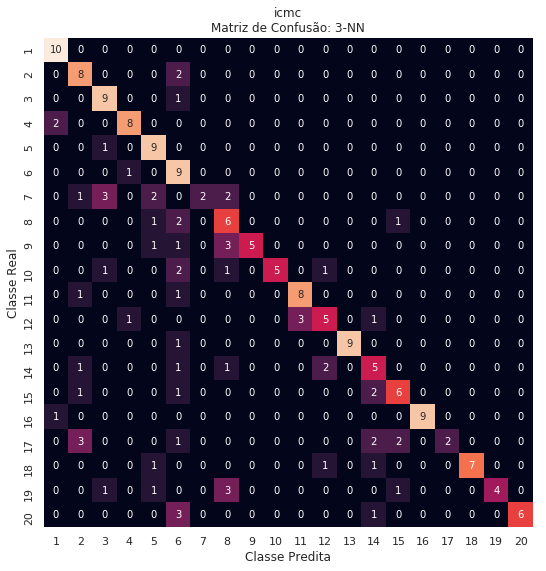

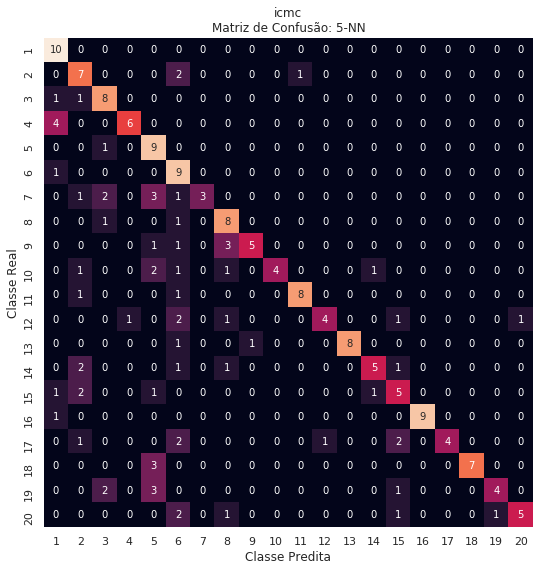

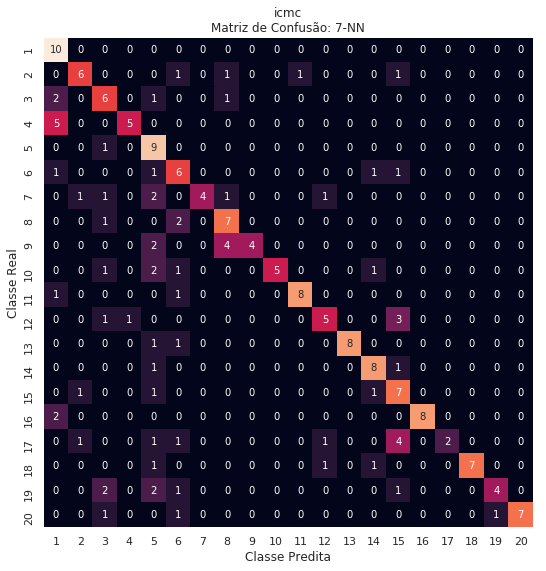

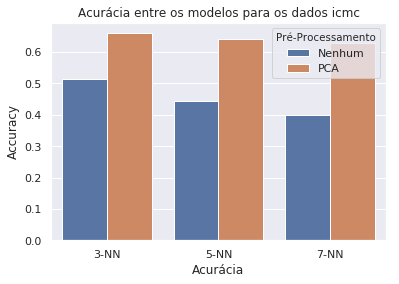

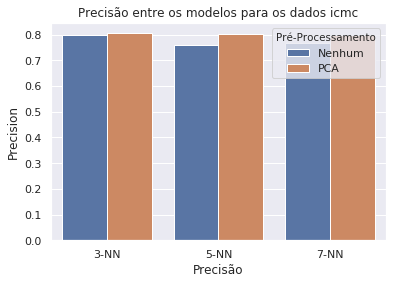

In [27]:
plot_result(icmc_matrix, name="icmc", use_hue=True, file_prefix="icmc_pca")

In [ ]:
plot_result(original_matrix, name="originais", use_hue=True, 
            file_prefix="orl_pca")